In [1]:
"""
    Import necessary packages in python 
"""
%matplotlib inline
import os
import sys 
import numpy as np 
import matplotlib as plt
from sklearn.model_selection import train_test_split
import seaborn
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
"""
OS Paths for loading dataset and assets
"""
cwd = os.getcwd()

DATA_PATH = os.path.join(cwd, "data")
UTILS_PATH = os.path.join(cwd, "utils")
MODELS_PATH = os.path.join(cwd, "models")

## Add the utils path 
sys.path.append(UTILS_PATH)
sys.path.append(MODELS_PATH)

#Use the utils path to load our data loader methods 
from utils import data_loader

hmnist_metadata = data_loader.load_HAM10000_metadata(DATA_PATH)
# Quick test:
# for f in os.listdir(DATA_PATH):
#     print(os.path.join(DATA_PATH, f))

#Import data 
# import 
# metadata = pd.read_csv(os.path.join(DATA_PATH, "HAM10000_metadata.csv"))
# hmnist8_8_L = data_loader.load_HAM10000_L(DATA_PATH)

hmnist_28_28_RGB = data_loader.load_HAM10000_RGB(DATA_PATH, False)

Found HAM10000 metadata file, loading into pandas df
Done
Found HAM10000 RGB images in size 28x28, reading into df
Done


In [3]:
hmnist_28_28_RGB.shape

(10015, 2353)

Size: (10015, 7)
Duplicates: 0
Nulls: 
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Nans: (57, 7)


<AxesSubplot:xlabel='label', ylabel='count'>

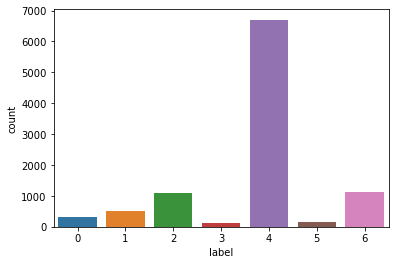

In [4]:
#EDA portion: 
def eda(dataframe):
    size = dataframe.shape
    duplicates = dataframe.duplicated().sum()
    nulls = dataframe.isnull().sum()
    nans = dataframe.isnull().any(axis=1)
    rows_with_nans = dataframe[nans]

    return print(f"Size: {size}\nDuplicates: {duplicates}\nNulls: \n{nulls}\n\nNans: {rows_with_nans.shape}")
    

eda(hmnist_metadata)


labels = hmnist_28_28_RGB["label"]
plt.figure.Figure()
seaborn.countplot(x=labels)

In [5]:
# resize the feature array
hmnist_28_28_RGB_feats = hmnist_28_28_RGB.drop(columns=["label"])
hmnist_reshape = np.array(hmnist_28_28_RGB_feats).reshape(-1, 28, 28, 3)

In [6]:
print(f"Reshaped Feature Set Shape: {hmnist_reshape.shape}")
print(f"Label Set Shape: {labels.shape}")

Reshaped Feature Set Shape: (10015, 28, 28, 3)
Label Set Shape: (10015,)


In [8]:
uint_hminst = hmnist_reshape.astype(np.uint8)
hmnist_images = []
VGG_INPUT_SiZE = (224, 224)
for i in uint_hminst:
    next_img = Image.fromarray(i)
    next_img.resize(VGG_INPUT_SiZE)
    hmnist_images.append(next_img)
    # hmnist_images.append(Image.fromarray(i))
    
np_hmnist_img = np.array(hmnist_images)
np_hmnist_img.shape

/Users/varunk/anaconda3/envs/4641project/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  # Remove the CWD from sys.path while we load stuff.
/Users/varunk/anaconda3/envs/4641project/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while

(10015,)

In [9]:
#Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(np_hmnist_img, labels, train_size=0.8)#

In [10]:
# Create an encoding of the labels into one-hot array

y_train = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=7)

In [11]:
print(f"Shapes: \n \tX_train: {X_train.shape}\n\ty_train: {y_train.shape}\n\tX_test: {X_test.shape}\n\ty_test: {y_test.shape}")

Shapes: 
 	X_train: (8012,)
	y_train: (8012, 7)
	X_test: (2003,)
	y_test: (2003, 7)


In [12]:
# Split the training set into a training and validation set.  The (X_test, y_test) will be used for predictions/confusion matrix 

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.8) #also 0.8? for more validation loss behavior 

print(f"----- Training Set Sizes -----")
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\n")
print(f"----- Validation Set Sizes -----")
print(f"X_validate: {X_validate.shape}\ny_validate: {y_validate.shape}\n")
print(f"----- Test/Prediction Set Sizes -----")
print(f"X_test: {X_test.shape}\ny_test: {y_test.shape}")

----- Training Set Sizes -----
X_train: (6409,)
y_train: (6409, 7)

----- Validation Set Sizes -----
X_validate: (1603,)
y_validate: (1603, 7)

----- Test/Prediction Set Sizes -----
X_test: (2003,)
y_test: (2003, 7)


----- Displaying Sample Images from Train Set ------
Location: (0, 0): [0. 0. 0. 0. 0. 0. 1.]
Location: (0, 1): [0. 0. 0. 1. 0. 0. 0.]
Location: (1, 0): [0. 1. 0. 0. 0. 0. 0.]
Location: (1, 1): [0. 1. 0. 0. 0. 0. 0.]



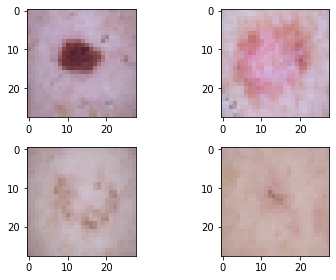

In [13]:
# Show Sample Images from Training Set 
figure, axes = plt.pyplot.subplots(2, 2)
train_set_size = X_train.shape[0]
tumor_types = ""
for i in range(2):
  for j in range(2):
    k = np.random.choice(np.arange(train_set_size))
    axes[i, j].imshow(X_train[k])
    tumor_types += f"Location: ({i}, {j}): {y_train[k]}\n"
print("----- Displaying Sample Images from Train Set ------")
plt.pyplot.tight_layout()
print(tumor_types)

In [22]:
### Create the NN Model 

#Fixed things
CONV_WINDOW = (3,3)

from models import model_defs

#Model decision:
# model = model_defs.basic_conv_2_stage(convolution_window=CONV_WINDOW)
model = model_defs.modded_VGG()


model.summary()

NameError: name 'tensorflow' is not defined

In [ ]:
from keras import backend as K
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def prec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = prec(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])

In [ ]:
#Callbacks used to stop learning early
learning_rate_reduction = ReduceLROnPlateau(monitor='val_f1', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=10)

In [ ]:
#Image data generator, used to create a wider variety of images from the train set 
gen = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False,
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False,
    zca_whitening=False, 
    
    rotation_range=30, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    zoom_range=0.1,
    horizontal_flip=False, vertical_flip=False
)
gen.fit(X_train)

In [ ]:
# Fit the neural network model using our callbacks and an expanded dataset using imageGenerator

MAX_EPOCH = 75
BATCH_SIZE=32 #smaller batch size than previous model 
VALIDATION_DATA = (X_validate, y_validate)
STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE
CALLBACKS = [learning_rate_reduction, early_stop]

training_history = model.fit_generator(
    gen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=MAX_EPOCH,
    verbose=1,
    callbacks=CALLBACKS,
    validation_data=VALIDATION_DATA
)

In [ ]:
loss, accuracy, *all_others = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v, *all_others_2 = model.evaluate(X_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.pyplot.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.pyplot.show()


plot_model_history(training_history)

In [ ]:
# Test the model with X_Test and y_Test
#Use a confusion matrix to see the number of incorrect predictions 

y_predicted = model.predict(X_test)
predicted_classes = np.argmax(y_predicted, axis=1)
actual_classes = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix 

matrix = confusion_matrix(actual_classes, predicted_classes,)
fmatrix = matrix
# fmatrix = matrix.astype('float') / matrix.sum(axis=1)

In [ ]:
import seaborn as sns 
plt.pyplot.figure(figsize = (10,7))

sns.heatmap(fmatrix, annot=True, fmt='.2f', cmap="YlGnBu")